### Naive Bayes Classifier

##### Using Gaussian formula for numerical features and directly using the conditional probability formula for categorical features
#### Only preprocessing is done using Sklearn but model is implemented using formulae from scratch

In [25]:
import pandas as pd
import numpy as np
import math as m
import scipy.stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot

In [3]:
train = pd.read_csv("bayestrain.csv")
test = pd.read_csv('bayestest.csv')
train

,age,sex,cp,trestbps,chol,target
0,57,1,2,128,229,0
1,52,1,1,128,205,1
2,44,1,0,120,169,0
3,60,1,2,140,185,0
4,41,0,1,105,198,1
...,...,...,...,...,...,...
237,47,1,2,130,253,1
238,66,1,0,112,212,0
239,62,1,1,120,281,0
240,63,0,1,140,195,1


#### EDA

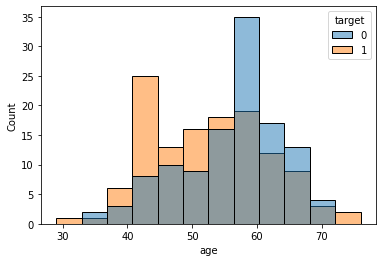

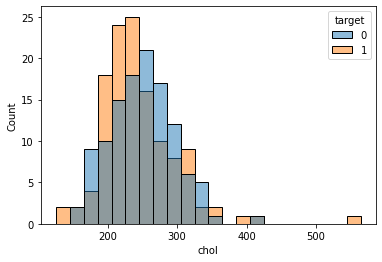

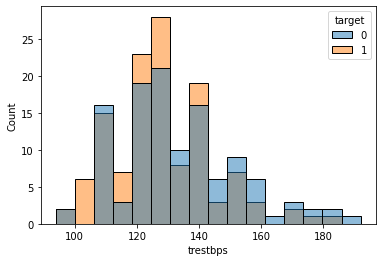

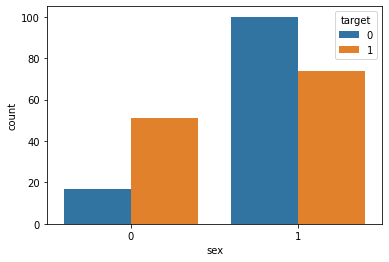

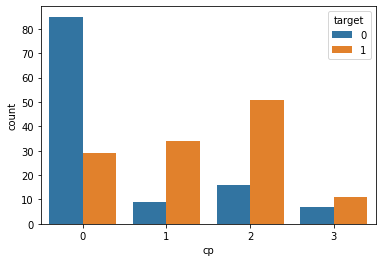

In [31]:
sns.histplot(x = "age",hue  = "target", data = train)
plt.show()
sns.histplot(x = "chol",hue  = "target", data = train)
plt.show()
sns.histplot(x = "trestbps",hue  = "target", data = train)
plt.show()
sns.countplot(x = "sex",hue  = "target", data = train)
plt.show()
sns.countplot(x = "cp",hue  = "target", data = train)
plt.show()

### Feature Preprocessing

In [443]:
# converting categorical data into one hot features
# Removing the sex column from the middle and joining it at the end
train = pd.get_dummies(train,columns = ["cp"])
test = pd.get_dummies(test,columns = ["cp"])
x = train.pop("sex")
train["sex"] = x
y = test.pop("sex")
test["sex"] = y
train

,age,trestbps,chol,target,cp_0,cp_1,cp_2,cp_3,sex
0,57,128,229,0,0,0,1,0,1
1,52,128,205,1,0,1,0,0,1
2,44,120,169,0,1,0,0,0,1
3,60,140,185,0,0,0,1,0,1
4,41,105,198,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
237,47,130,253,1,0,0,1,0,1
238,66,112,212,0,1,0,0,0,1
239,62,120,281,0,0,1,0,0,1
240,63,140,195,1,0,1,0,0,0


#### Finding the mean and variance of non Standardized data

In [444]:
mean_table_un = train.groupby(["target"]).mean()
std_table_un = train.groupby(["target"]).std()

In [445]:
mean_table_un

,age,trestbps,chol,cp_0,cp_1,cp_2,cp_3,sex
target,,,,,,,,
0,56.153846,133.777778,249.068376,0.726496,0.076923,0.136752,0.059829,0.854701
1,52.560000,128.408000,245.616000,0.232000,0.272000,0.408000,0.088000,0.592000


In [446]:
std_table_un

,age,trestbps,chol,cp_0,cp_1,cp_2,cp_3,sex
target,,,,,,,,
0,7.952028,18.592319,46.305717,0.447675,0.267615,0.345063,0.238190,0.353918
1,9.398353,16.053889,56.724971,0.423808,0.446781,0.493441,0.284435,0.493441


#### Probabilities of classes P(c1) and P(c2)

In [452]:
P0 = len(train[train["target"]==0])/len(train)
P1 = 1 - P0
P0

0.4834710743801653


### Gaussian Probability - P(xk / cj)

In [453]:
def prob_Xk_Cj(xk,uj,vj):
    
   # P = (1/m.sqrt(2*m.pi*(vj**2))*m.exp(-(xk-uj)**2/(2*(vj**2))))
    P = scipy.stats.norm.pdf(xk,uj,vj)
    
    return P

In [454]:
sum_table = train.groupby("target").sum()
count_table = train.groupby("target").count()
sum_table

,age,trestbps,chol,cp_0,cp_1,cp_2,cp_3,sex
target,,,,,,,,
0,6570,15652,29141,85,9,16,7,100
1,6570,16051,30702,29,34,51,11,74


#### Probability - P(x) Unstandardized

In [455]:
def P_N_UN(x):
    
    Px0 = 1
    Px1 = 1
    
    for i in range(3):
    
        mean0 = mean_table_un.iloc[0,i]
        std0 = std_table_un.iloc[0,i]
    
        prob0 = prob_Xk_Cj(x[i],mean0,std0)

        mean1 = mean_table_un.iloc[1,i]
        std1 = std_table_un.iloc[1,i]
        
        prob1 = prob_Xk_Cj(x[i],mean1,std1)
        
        Px0 = Px0 * prob0
        
        Px1 = Px1 * prob1

    
    for i  in range(3,7):
        
        if x[i] == 1:
            prob0  = sum_table.iloc[0,i]/count_table.iloc[0,i]
            prob1  = sum_table.iloc[1,i]/count_table.iloc[1,i]
        else:
            prob0  = 1 - (sum_table.iloc[0,i]/count_table.iloc[0,i])
            prob1  = 1 - (sum_table.iloc[1,i]/count_table.iloc[1,i])
            
            
        Px0 = Px0 * prob0
        
        Px1 = Px1 * prob1
        
        
    return Px0,Px1

#### Naive Bayes classifier - P(cj  /xk)

#### Without Standardization

In [457]:
def Naive_bayes_Un(x):
    
    px0,px1 = P_N_UN(x)
    
    P0x = px0 * P0/(px0*P0 + px1*P1)
    P1x = px1 * P1/(px0*P0 + px1*P1)
    if P0x>P1x:
    
        return 0
    else:
    
        return 1

In [458]:
test_array = np.concatenate((np.array(test.iloc[:,0:3]),np.array(test.iloc[:,4:8])),axis =1) 
actual_value = np.array(test.iloc[:,3]).reshape(len(test_array),1)

In [459]:
target = np.zeros((len(test_array),1))
for i in range(len(test_array)):
    target[i] = Naive_bayes_Un(test_array[i])

In [460]:
wrong_class = sum((target - actual_value)**2)/len(test_array)
print("Percentage of correctly classified data - ",(1-wrong_class)[0]*100)

Percentage of correctly classified data -  78.68852459016394


### With Standardization

#### Mean and variance of Standardized data

In [447]:
train1 = train.copy(deep=True)
test1 = test.copy(deep=True)
standardize = StandardScaler()
standardize.fit(train[["age","trestbps","chol"]])
train1[["age","trestbps","chol"]] = standardize.transform(train[["age","trestbps","chol"]])
test1[["age","trestbps","chol"]] = standardize.transform(test[["age","trestbps","chol"]])

In [461]:
train1

,age,trestbps,chol,target,cp_0,cp_1,cp_2,cp_3,sex
0,0.304446,-0.172029,-0.353239,0,0,0,1,0,1
1,-0.258826,-0.172029,-0.816879,1,0,1,0,0,1
2,-1.160062,-0.630142,-1.512340,0,1,0,0,0,1
3,0.642410,0.515140,-1.203247,0,0,0,1,0,1
4,-1.498025,-1.489103,-0.952108,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
237,-0.822099,-0.057501,0.110402,1,0,0,1,0,1
238,1.318337,-1.088255,-0.681651,0,1,0,0,0,1
239,0.867719,-0.630142,0.651316,0,0,1,0,0,1
240,0.980373,0.515140,-1.010063,1,0,1,0,0,0


In [462]:
mean_table_n = train1.groupby(["target"]).mean()
std_table_n = train1.groupby(["target"]).std()

In [463]:
mean_table_n


,age,trestbps,chol,cp_0,cp_1,cp_2,cp_3,sex
target,,,,,,,,
0,0.209123,0.158830,0.034450,0.726496,0.076923,0.136752,0.059829,0.854701
1,-0.195740,-0.148665,-0.032245,0.232000,0.272000,0.408000,0.088000,0.592000


In [464]:
std_table_n

,age,trestbps,chol,cp_0,cp_1,cp_2,cp_3,sex
target,,,,,,,,
0,0.895832,1.064672,0.894551,0.447675,0.267615,0.345063,0.238190,0.353918
1,1.058767,0.919312,1.095834,0.423808,0.446781,0.493441,0.284435,0.493441


### Conditional Probabilities

In [465]:
def P_N_N(x):
    
    Px0 = 1
    Px1 = 1
    
    for i in range(3):
    
        mean0 = mean_table_n.iloc[0,i]
        std0 = std_table_n.iloc[0,i]
    
        prob0 = prob_Xk_Cj(x[i],mean0,std0)

        mean1 = mean_table_n.iloc[1,i]
        std1 = std_table_n.iloc[1,i]
        
        prob1 = prob_Xk_Cj(x[i],mean1,std1)
        
        Px0 = Px0 * prob0
        
        Px1 = Px1 * prob1

    
    for i  in range(3,7):
        
        if x[i] == 1:
            prob0  = sum_table.iloc[0,i]/count_table.iloc[0,i]
            prob1  = sum_table.iloc[1,i]/count_table.iloc[1,i]
        else:
            prob0  = 1 - (sum_table.iloc[0,i]/count_table.iloc[0,i])
            prob1  = 1 - (sum_table.iloc[1,i]/count_table.iloc[1,i])
            
            
        Px0 = Px0 * prob0
        
        Px1 = Px1 * prob1
        

    return Px0,Px1

#### Naive Bayes classifier - P(cj  /xk) with standardizatioabsn

In [472]:
def Naive_bayes_n(x):
    
    px0,px1 = P_N_N(x)
    
    P0x = px0 * P0/(px0*P0 + px1*P1)
    P1x = px1 * P1/(px0*P0 + px1*P1)

    if P0x>P1x:
    
        return 0
    else:
    
        return 1

In [467]:
test_array = np.concatenate((np.array(test1.iloc[:,0:3]),np.array(test1.iloc[:,4:8])),axis =1) 
actual_value = np.array(test1.iloc[:,3]).reshape(len(test_array),1)

In [468]:
target = np.zeros((len(test_array),1))
for i in range(len(test_array)):
    target[i] = Naive_bayes_n(test_array[i])

In [469]:
wrong_class = sum((target - actual_value)**2)/len(test_array)
print("Percentage of correctly classified data - ",(1-wrong_class)[0]*100)

Percentage of correctly classified data -  78.68852459016394


In [470]:
from sklearn.metrics import confusion_matrix  
cm = confusion_matrix(actual_value, target)  
print(cm)

[[19  2]
 [11 29]]


### Using Sklearn Library 

In [473]:
from sklearn.naive_bayes import GaussianNB
train = pd.read_csv("bayestrain.csv")
test = pd.read_csv('bayestest.csv')
train

X = train.iloc[:,:-1]
y = train.iloc[:,-1]

testX = test.iloc[:,:-1]
testY = test.iloc[:,-1]

model = GaussianNB()
model.fit(X,y)
pred = model.predict(testX)

In [426]:
from sklearn.metrics import accuracy_score
accuracy_score(testY, pred) 

0.7704918032786885

In [309]:
from sklearn.metrics import confusion_matrix  
cm = confusion_matrix(testY, pred)  
print(cm)

[[13  8]
 [ 6 34]]


#### Accuracy of own model without Standardization = 78.7 %
#### Accuracy of own model with Standardization = 78.7 %
#### Accuracy of Naive Bayes Classifier = 77.05 %

## Result: Standardization has no effect in naive bayes classifier